In [1]:
import anndata as ad
import datetime
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import scanpy
import spikeinterface.core as sc
import spikeinterface.extractors as se 
import spikeinterface.widgets as sw
import re

In [34]:
window_ms = 500
bin_ms = 15
isi_threshold_ms = 1.5
n_day_per_4week = 28
n_week_tracked = 36
n_ms_per_s = 1000
save_dates = {
    '1_5': '20240219',
    '5_7': '20240220',
}
init_dates = {
    '1_5': '20230627',
    '5_7': '20230805',
}
longterm_segments = {
    '1_5': {
        # 2: [3, 5, 6, 11],
        # 7: [2, 4, 6, 8],
        # 9: [3, 4, 7, 9],
        # 16: [3, 5, 6, 9, 13], 
        # 21: [3, 5, 7, 9, 12],
        # 30: [3, 4, 6, 9, 12],
        # 41: [3, 4, 6, 9, 13],
        # 43: [3, 4, 6, 9, 12],
        # 49: [3, 4, 6, 9], 
        # 51: [3, 4, 6, 11, 12],
        # 63: [3, 4, 7, 9],
        # 2 6, 10, 14
        63: [1, 3, 5, 7, ]
    },
    '5_7': {
        15: [4, 6, 8, 11],
        18: [4, 6, 9, 13], 
        21: [4, 6, 9, 11],
        23: [4, 6, 9, 11],
        24: [4, 5, 9, 11],
        28: [4, 5, 9, 11],
        32: [4, 6, 8, 13],
        34: [4, 6, 9, 13],
        37: [4, 6, 9, 13],
        38: [4, 6, 10, 13],
        39: [4, 6, 10, 11],
        40: [4, 5, 9, 13],
        42: [4, 6, 10, 13],
        43: [4, 6, 9, 13],
        44: [4, 6, 9, 13],
    }
}

def read_spikeinterface(subject):
    recording = sc.load_extractor(f'data/processed/LongTerm/{subject}/{save_dates[subject]}/recording')
    sorting = se.NpzSortingExtractor(f'data/processed/LongTerm/{subject}/{save_dates[subject]}/sorting4/sorter_output/firings.npz')
    return recording, sorting

In [3]:
channel_indices = np.array([ 
    [ 5,  3,  1,  7,  9, 11], 
    [17, 15, 13, 19, 21, 23], 
    [29, 27, 25, 28, 26, 24], 
    [18, 20, 22, 16, 14, 12], 
    [ 6,  8, 10,  4,  2,  0],
])
def get_shank(channel_index):
    for shank, shank_channels in enumerate(channel_indices):
        if channel_index in shank_channels:
            return shank 
    raise Exception

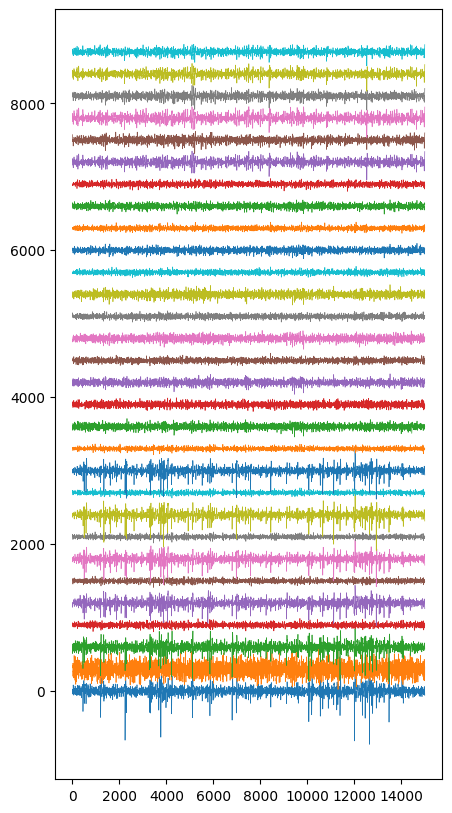

In [4]:
recording, sorting = read_spikeinterface('1_5')
zoom_out_start_frame = int(4274.5*recording.sampling_frequency)
zoom_out_end_frame = int(4275*recording.sampling_frequency)
plt.figure(figsize=(5, 10))
zoom_out_traces = recording.get_traces(start_frame=zoom_out_start_frame, end_frame=zoom_out_end_frame).T

gap = 300
for trace_index, trace in enumerate(zoom_out_traces):
    plt.plot(trace + trace_index * gap, linewidth=0.5)
plt.show() 
plt.close()

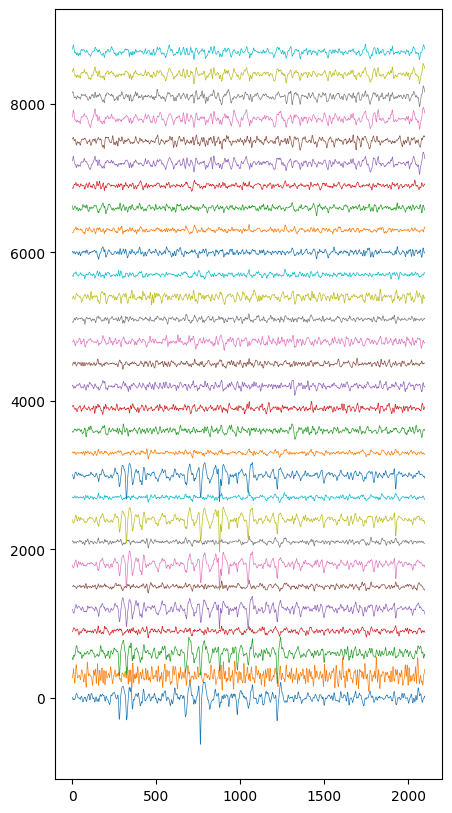

In [5]:
recording, sorting = read_spikeinterface('1_5')
zoom_in_start_frame = int(4274.6*recording.sampling_frequency)
zoom_in_end_frame = int(4274.67*recording.sampling_frequency)
plt.figure(figsize=(5, 10))
zoom_in_traces = recording.get_traces(start_frame=zoom_in_start_frame, end_frame=zoom_in_end_frame).T

gap = 300
for trace_index, trace in enumerate(zoom_in_traces):
    plt.plot(trace + trace_index * gap, linewidth=0.5)
plt.show() 
plt.close()

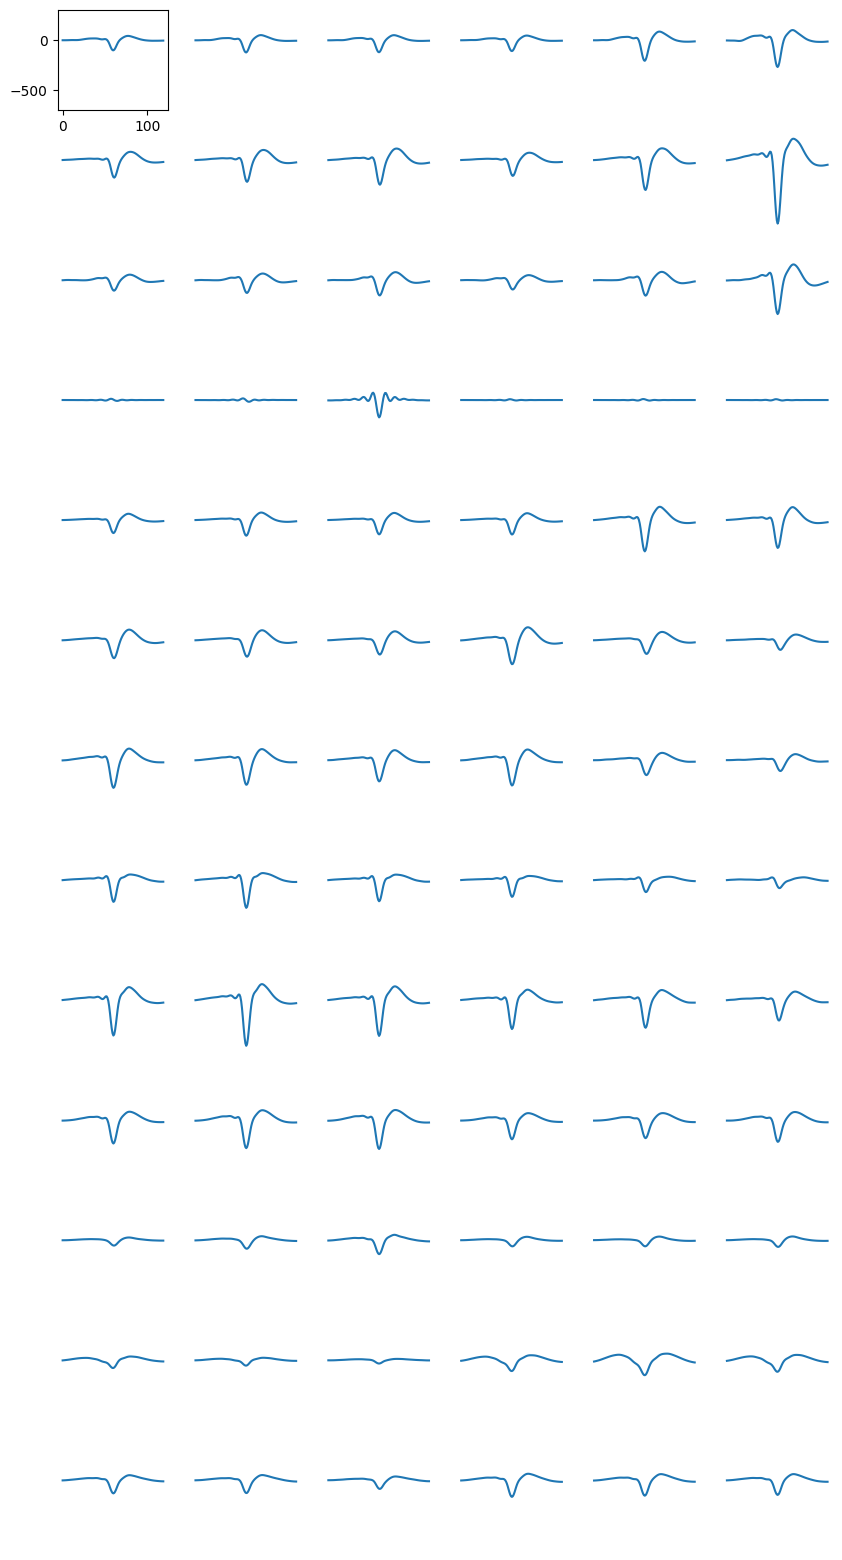

In [7]:
recording, sorting = read_spikeinterface('1_5')
waveform_extractor = sc.load_waveforms(folder='data/processed/LongTerm/1_5/20240219/waveform4/3', with_recording=False, sorting=sorting)
extremum_channels = sc.get_template_extremum_channel(waveform_extractor)
zoomed_unit_ids = []
for unit_id in sorting.unit_ids:
    if sorting.get_unit_spike_train(unit_id=unit_id, start_frame=zoom_out_start_frame, end_frame=zoom_out_end_frame).size > 0:
        zoomed_unit_ids.append(unit_id)

zoomed_templates = waveform_extractor.get_all_templates(unit_ids=zoomed_unit_ids)

gap = 500
ncols = 6 # n_channels
nrows = len(zoomed_unit_ids)

plt.figure(figsize=(10, 20))
axis_off = False
for unit_index in range(nrows):
    for channel_index in range(ncols):
        ax = plt.subplot(nrows, ncols, unit_index*ncols+channel_index+1)
        shank = get_shank(extremum_channels[zoomed_unit_ids[unit_index]])
        ax.plot(zoomed_templates[unit_index, :, channel_indices[shank][channel_index]])
        ax.set_ylim(-700, 300)
        if axis_off:
            ax.set_axis_off()
        if not axis_off: 
            axis_off = True
plt.show()
plt.close()

unit  2 segment  3 week  4
unit  2 segment  5 week  8
unit  2 segment  6 week 12
unit  2 segment 11 week 20

unit  7 segment  2 week  4
unit  7 segment  4 week  8
unit  7 segment  6 week 12
unit  7 segment  8 week 16

unit  9 segment  3 week  4
unit  9 segment  4 week  8
unit  9 segment  7 week 16
unit  9 segment  9 week 16

unit 16 segment  3 week  4
unit 16 segment  5 week  8
unit 16 segment  6 week 12
unit 16 segment  9 week 16
unit 16 segment 13 week 24

unit 21 segment  3 week  4
unit 21 segment  5 week  8
unit 21 segment  7 week 16
unit 21 segment  9 week 16
unit 21 segment 12 week 20

unit 30 segment  3 week  4
unit 30 segment  4 week  8
unit 30 segment  6 week 12
unit 30 segment  9 week 16
unit 30 segment 12 week 20

unit 41 segment  3 week  4
unit 41 segment  4 week  8
unit 41 segment  6 week 12
unit 41 segment  9 week 16
unit 41 segment 13 week 24

unit 43 segment  3 week  4
unit 43 segment  4 week  8
unit 43 segment  6 week 12
unit 43 segment  9 week 16
unit 43 segment 12 we

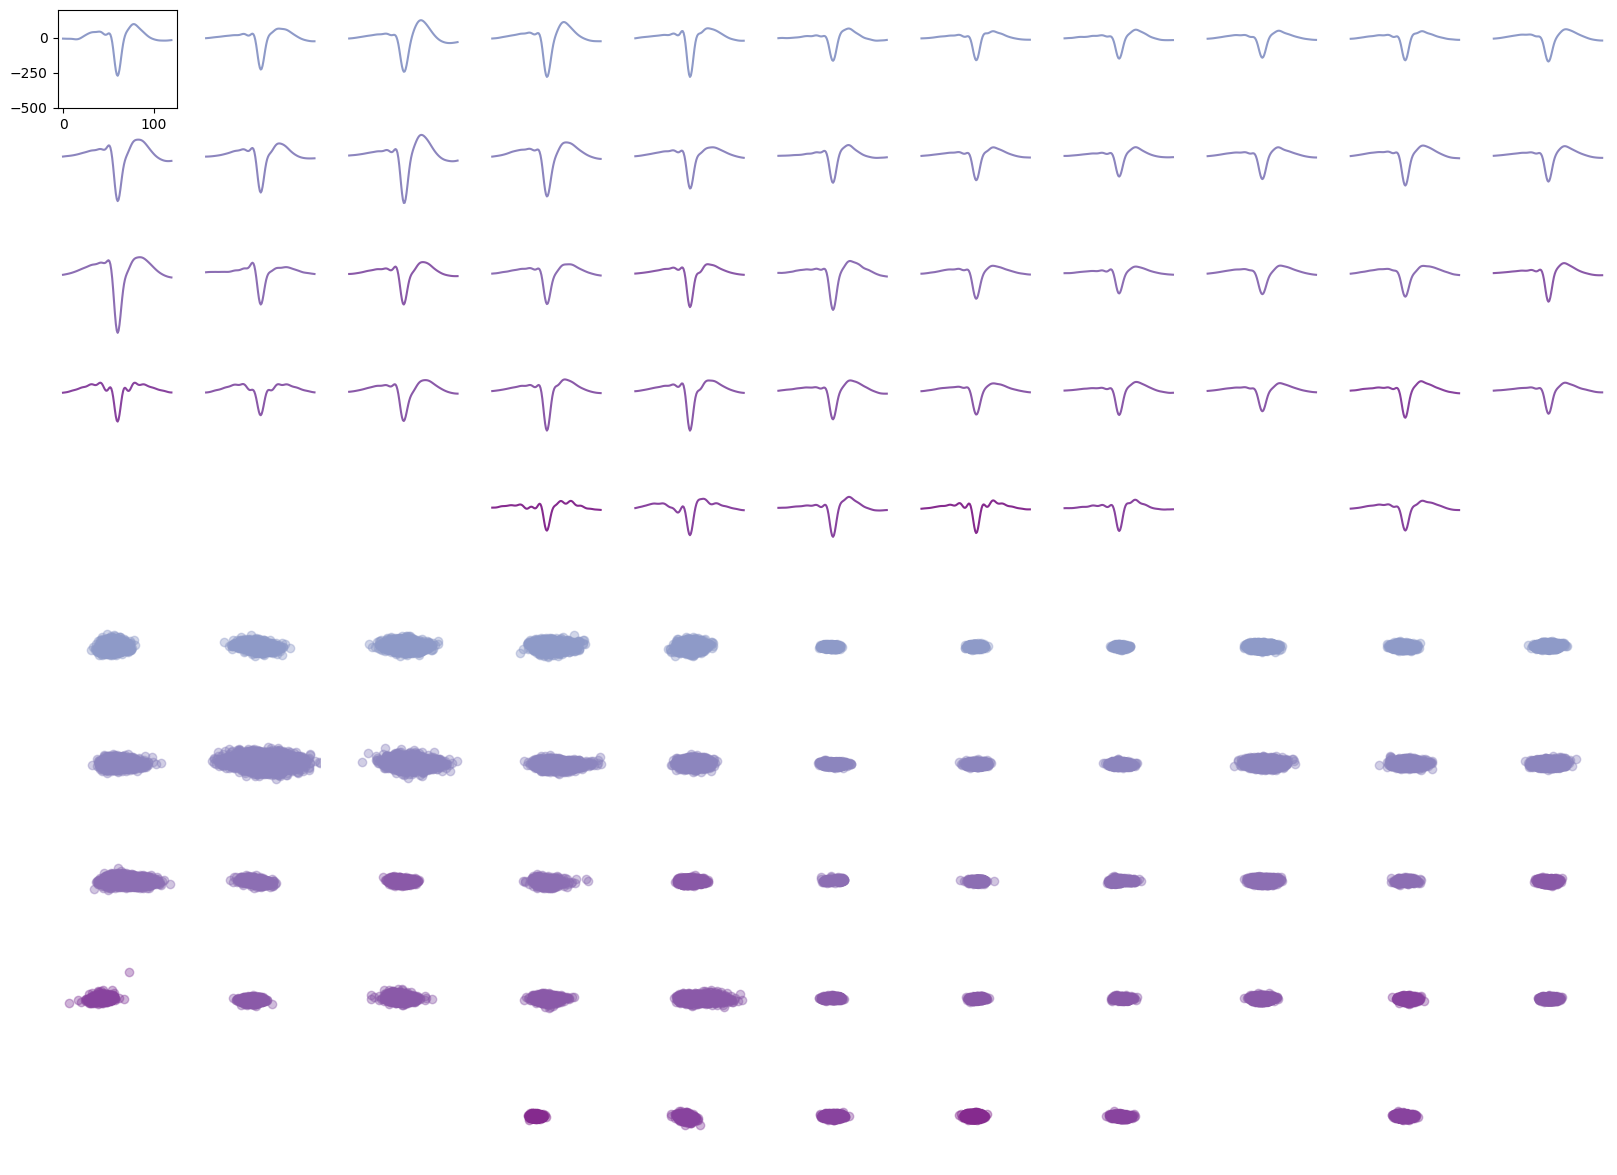

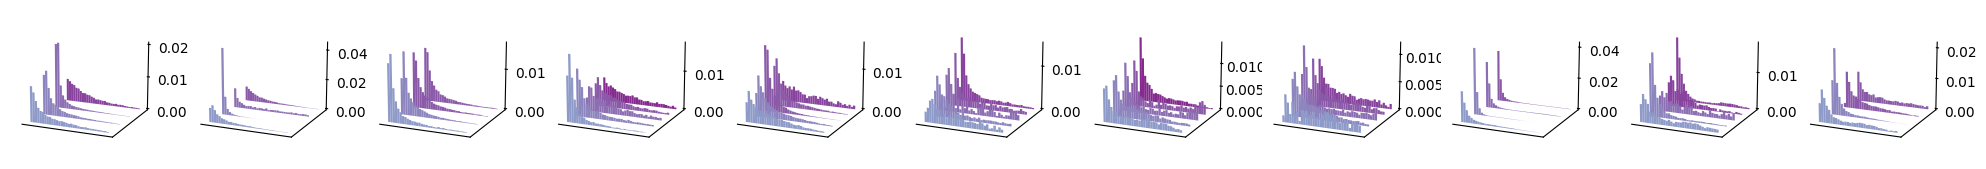

In [48]:
def compute_isi_violation_rate(spike_train_ms, window_ms, bin_ms, isi_threshold_ms):
    bins = np.arange(0, window_ms, bin_ms)
    isi = np.diff(spike_train_ms)
    if (len(isi) == 0) or (isi.min() > window_ms):
        return [], [], 0
    else:
        ys, bin_edges = np.histogram(isi, bins=bins, density=True)
        xs = bin_edges[:-1]
        rate = (isi < isi_threshold_ms).sum() / len(isi)
        return xs, ys, rate
    
subject = '1_5'
recording, sorting = read_spikeinterface(subject)
adatas, lapses, templates, isis = [], [], [], []
session_info = pd.read_csv(f'data/processed/LongTerm/{subject}/{save_dates[subject]}/session_info.csv')
for unit_id, segments in longterm_segments[subject].items():
    unit_adatas, unit_lapses, unit_templates, unit_waveforms, unit_isis = [], [], [], [], []
    for segment in segments:
        segment_waveform_extractor = sc.load_waveforms(
            folder=f'data/processed/LongTerm/{subject}/{save_dates[subject]}/waveform4/{segment}', with_recording=False, sorting=sorting
        )
        segment_extremum_channels = sc.get_template_extremum_channel(segment_waveform_extractor)
        segment_shank = get_shank(segment_extremum_channels[unit_id])

        match = re.search(r'(\d{4})(\d{2})(\d{2})', session_info['path'][segment])
        segment_lapse = round((datetime.datetime.strptime(match.group(0), '%Y%m%d') - datetime.datetime.strptime(init_dates[subject], '%Y%m%d')).days / n_day_per_4week) * 4
        unit_lapses.append(segment_lapse)

        unit_templates.append(segment_waveform_extractor.get_template(unit_id=unit_id)[:, segment_extremum_channels[unit_id]])

        segment_waveforms = segment_waveform_extractor.get_waveforms(unit_id=unit_id)[:, :, channel_indices[segment_shank]]
        unit_waveforms.append(segment_waveforms.transpose(0, 2, 1).reshape(segment_waveforms.shape[0], segment_waveforms.shape[1]*segment_waveforms.shape[2]))

        n_frames_per_ms = sorting.sampling_frequency / n_ms_per_s
        segment_spike_train_ms = sorting.get_unit_spike_train(unit_id=unit_id, start_frame=session_info['session_start'][segment], end_frame=session_info['session_start'][segment]+session_info['session_length'][segment]) / n_frames_per_ms
        unit_isis.append(compute_isi_violation_rate(segment_spike_train_ms, window_ms, bin_ms, isi_threshold_ms))

        print(f'unit {unit_id:2d} segment {segment:2d} week {segment_lapse:2d}')
    
    lapses.append(unit_lapses)
    templates.append(unit_templates)
    isis.append(unit_isis)

    unit_adata = ad.AnnData(np.vstack(unit_waveforms))
    unit_adata.obs['segment'] = np.hstack([[segment] * len(segment_waveforms) for segment, segment_waveforms in enumerate(unit_waveforms)])
    scanpy.tl.pca(unit_adata)
    adatas.append(unit_adata)
    print()

nrows = 10
ncols = len(longterm_segments[subject])

plt.figure(figsize=(20, 15))
for row in range(nrows // 2):
    for col in range(ncols):
        if row < len(lapses[col]):
            color = plt.cm.BuPu(0.42 + 0.58 * lapses[col][row] / n_week_tracked)
            ax = plt.subplot(nrows, ncols, col + row * ncols + 1)
            ax.plot(templates[col][row], color=color)
            ax.set_ylim(-500, 200)
            if not (col == row == 0): ax.set_axis_off()
        
            ax = plt.subplot(nrows, ncols, col + (row + nrows // 2) * ncols + 1)
            segment_adata = adatas[col][adatas[col].obs['segment'] == row]
            ax.scatter(segment_adata.obsm['X_pca'][:, 0], segment_adata.obsm['X_pca'][:, 1], color=color, alpha=0.4)
            ax.set_ylim(-15000, 15000)
            ax.set_xlim(-5000, 5000)
            ax.set_axis_off()
plt.show()
plt.close()

def erase_3D_pane(ax):
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

plt.figure(figsize=(25, 5))
for col in range(ncols):
    ax = plt.subplot(1, ncols, col + 1, projection='3d')
    ax.view_init(15, -66, 0)
    erase_3D_pane(ax)
    for row in range(nrows // 2):
        if row < len(lapses[col]):
            color = plt.cm.BuPu(0.42 + 0.58 * lapses[col][row] / n_week_tracked)
            ax.bar(isis[col][row][0], isis[col][row][1], zs=row, zdir='y', width=bin_ms, align="edge", color=color)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_yticks([])
plt.show()
plt.close()